In [204]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import timeit
import re
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import plotly.express as px

In [205]:
election_results = pd.read_csv("../../webscraping_open_secrets-silver-ish-sharks/data/election_results.csv")

In [206]:
election_results.rename(columns={})

election_results

,Unnamed: 0,Candidate_name,Party,State,District,Incumbent,Winner,Raised,Spent,percent_raised,percent_spent
0,0,Jerry Carl,R,Alabama,1,False,True,1971321,1859349,96.095624,95.925703
1,1,James Averhart,D,Alabama,1,False,False,80095,78973,3.904376,4.074297
2,0,Barry Moore,R,Alabama,2,False,True,650807,669368,92.070532,92.281307
3,1,Phyllis Harvey,D,Alabama,2,False,False,56050,55988,7.929468,7.718693
4,0,Mike D Rogers,R,Alabama,3,True,True,1193111,1218564,95.956760,96.747133
...,...,...,...,...,...,...,...,...,...,...,...
889,1,Tricia Zunker,D,Wisconsin,7,False,False,1261957,1232690,32.362718,32.894277
890,0,Mike Gallagher,R,Wisconsin,8,True,True,3202905,2841801,88.480898,87.663451
891,1,Amanda Stuck,D,Wisconsin,8,False,False,416978,399916,11.519102,12.336549
892,0,Liz Cheney,R,Wyoming,1,True,True,3003883,3060167,95.711395,95.857821


In [207]:
URL_states = "https://www.britannica.com/topic/United-States-House-of-Representatives-Seats-by-State-1787120"
URL_abb = "https://www.50states.com/abbreviations.htm"

response_states = requests.get(URL_states)
response_abb = requests.get(URL_abb)

soup = BS(response_states.text)

soup_abb = BS(response_abb.text)

abb = pd.read_html(str(soup_abb.find('table')))[0]
abb = abb.drop(columns='STANDARD ABBREVIATION')
abb = abb.rename(columns={'US STATE':'state', 'POSTAL ABBREVIATION':'state_abb'})


states = pd.read_html(str(soup.find('table')))[0]
states = states.drop([50])

state_districts = pd.merge(states, abb, on='state')
state_districts['representatives'] = state_districts['representatives'].apply(pd.to_numeric)
display(state_districts.head())
district_count = "Number of US Representatives: " + str(state_districts['representatives'].sum())
district_count

,state,representatives,state_abb
0,Alabama,7,AL
1,Alaska,1,AK
2,Arizona,9,AZ
3,Arkansas,4,AR
4,California,53,CA


'Number of US Representatives: 435'

In [208]:
incumbent_win = election_results[(election_results['Incumbent'] == True) & (election_results['Winner'] == True)]
incumbent_win

,Unnamed: 0,Candidate_name,Party,State,District,Incumbent,Winner,Raised,Spent,percent_raised,percent_spent
4,0,Mike D Rogers,R,Alabama,3,True,True,1193111,1218564,95.956760,96.747133
6,0,Robert B Aderholt,R,Alabama,4,True,True,1255076,1323812,96.459423,96.710075
8,0,Mo Brooks,R,Alabama,5,True,True,655365,210045,100.000000,100.000000
9,0,Gary Palmer,R,Alabama,6,True,True,907219,909082,100.000000,100.000000
10,0,Terri Sewell,D,Alabama,7,True,True,2168165,1495957,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...
883,0,Gwen Moore,D,Wisconsin,4,True,True,1183995,1166739,100.000000,100.000000
886,0,Glenn S Grothman,R,Wisconsin,6,True,True,1815756,1736659,86.320334,87.601787
888,0,Tom Tiffany,R,Wisconsin,7,True,True,2637459,2514740,67.637282,67.105723
890,0,Mike Gallagher,R,Wisconsin,8,True,True,3202905,2841801,88.480898,87.663451


In [209]:
incumbent_agg = incumbent_win['State'].value_counts().reset_index()
incumbent_agg = incumbent_agg.rename(columns={'index':'state', 'State':'numb_incumb_wins'})
incumbent_agg['numb_incumb_wins'].sum()
#incumbent_agg.head()

371

In [210]:
incumbent_agg.head()

,state,numb_incumb_wins
0,California,47
1,Texas,29
2,Florida,22
3,New York,21
4,Pennsylvania,17


In [220]:
incumbent_agg = pd.merge(state_districts, incumbent_agg, how='outer').fillna(value=0)
incumbent_agg.head()

,state,representatives,state_abb,numb_incumb_wins,numb_incumb_losses,no_incumbent_run,perc_incumb_win,perc_incumbent_loss,perc_incumb_loss,perc_no_incumb_run
0,Alabama,7,AL,5.0,0.0,2.0,71.43,0.00,0.00,28.57
1,Alaska,1,AK,1.0,0.0,0.0,100.00,0.00,0.00,0.00
2,Arizona,9,AZ,9.0,0.0,0.0,100.00,0.00,0.00,0.00
3,Arkansas,4,AR,4.0,0.0,0.0,100.00,0.00,0.00,0.00
4,California,53,CA,47.0,3.0,3.0,88.68,5.66,5.66,5.66


In [221]:
incumbent_lost = election_results[(election_results['Incumbent']  == True) & (election_results['Winner'] == False)]
incumbent_lost.head()

,Unnamed: 0,Candidate_name,Party,State,District,Incumbent,Winner,Raised,Spent,percent_raised,percent_spent
76,0,TJ Cox,D,California,21,True,False,5695157,5694005,58.333867,58.843082
110,0,Gil Cisneros,D,California,39,True,False,4370133,4350464,40.484103,41.943847
126,0,Harley Rouda,D,California,48,True,False,5968858,6174443,48.628024,50.104893
226,0,Debbie Mucarsel,D,Florida,26,True,False,6793521,6822740,75.315529,75.723000
228,0,Donna Shalala,D,Florida,27,True,False,3842907,3735966,51.227128,50.578695


In [222]:
incumbent_lost = incumbent_lost['State'].value_counts()
incumbent_lost = pd.DataFrame(incumbent_lost)
incumbent_lost = incumbent_lost.reset_index()
incumbent_lost =incumbent_lost.rename(columns={'index':'state', 'State':'numb_incumb_losses'})
incumbent_lost

,state,numb_incumb_losses
0,California,3
1,New York,2
2,Florida,2
3,Utah,1
4,South Carolina,1
5,Iowa,1
6,Hawaii,1
7,Pennsylvania,1
8,New Mexico,1
9,Minnesota,1


In [223]:
incumbent_agg = pd.merge(incumbent_agg, incumbent_lost, how="outer").fillna(value = 0)

incumbent_agg['no_incumbent_run'] = incumbent_agg['representatives'] - incumbent_agg['numb_incumb_wins'] - incumbent_agg['numb_incumb_losses']
incumbent_agg['perc_incumb_win'] = (incumbent_agg['numb_incumb_wins']/incumbent_agg['representatives'] * 100).round(decimals=2)
incumbent_agg['perc_incumb_loss'] = (incumbent_agg['numb_incumb_losses']/incumbent_agg['representatives'] * 100).round(decimals=2)
incumbent_agg['perc_no_incumb_run'] = (incumbent_agg['no_incumbent_run']/incumbent_agg['representatives'] * 100).round(decimals=2)

incumbent_agg.head()

,state,representatives,state_abb,numb_incumb_wins,numb_incumb_losses,no_incumbent_run,perc_incumb_win,perc_incumbent_loss,perc_incumb_loss,perc_no_incumb_run
0,Alabama,7,AL,5.0,0.0,2.0,71.43,0.00,0.00,28.57
1,Alaska,1,AK,1.0,0.0,0.0,100.00,0.00,0.00,0.00
2,Arizona,9,AZ,9.0,0.0,0.0,100.00,0.00,0.00,0.00
3,Arkansas,4,AR,4.0,0.0,0.0,100.00,0.00,0.00,0.00
4,California,53,CA,47.0,3.0,3.0,88.68,5.66,5.66,5.66


In [240]:
all_incumb_win_perc = (incumbent_agg['perc_incumb_win'].sum() / incumbent_agg['perc_incumb_win'].count()).round(decimals=2)
print(all_incumb_win_perc)

all_incumb_loss_perc = (incumbent_agg['perc_incumb_loss'].sum() / incumbent_agg['perc_incumb_loss'].count()).round(decimals=2)
print(all_incumb_loss_perc)

all_no_incumb_run_perc = (incumbent_agg['perc_no_incumb_run'].sum() / incumbent_agg['perc_no_incumb_run'].count()).round(decimals=2)
print(all_no_incumb_run_perc)


83.79
4.12
12.09


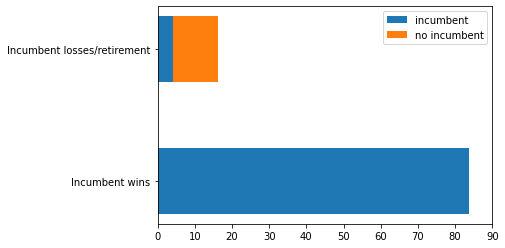

In [247]:
labels = ['Incumbent wins', 'Incumbent losses/retirement']

results = [all_incumb_win_perc, all_incumb_loss_perc]
i_none = [0, all_no_incumb_run_perc]
width = 0.5

fig, ax = plt.subplots()

ax.barh(labels, results, width, label = "incumbent")
ax.barh(labels, i_none, width, left = results, label = "no incumbent")
ax.set_xticks(np.arange(0, 91, 10))
ax.legend()

plt.show()

In [ ]:
fig = px.sunburst(val)